In [1]:
import numpy as np
import nibabel as nib
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import sys
from pathlib import Path
from typing import List, Union

sys.path.append("..")

from preprocessing import (
    sample_weights, 
    dilated_sample_weights,
    min_max_normalization, 
    get_idxs_of_annotated_slices, 
)

2023-07-11 20:53:41.751738: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-11 20:53:41.968159: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Helpers

In [2]:
def exists(obj):
    return obj is not None

def window_image(image: np.ndarray, window_center: int, window_width: int) -> np.ndarray:
    """Returns a transformed image centered a `window_center`. The resulting image range is: 
    [`window_center` - `window_width` //2, `window_center` + `window_width` //2]"""
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    return window_image

def denorm_ct(arr: np.ndarray) -> np.ndarray:
    """Denormalize the given numpy array using z-score normalization. Values are fixed for
    because we know before hand about the min and max values."""
    MIN_VAL, MAX_VAL = -100, 400
    return arr * (MAX_VAL - MIN_VAL) + (MIN_VAL)

# Example

Uncomment the lines if you wish to save images to visalize them on MRIcroGL

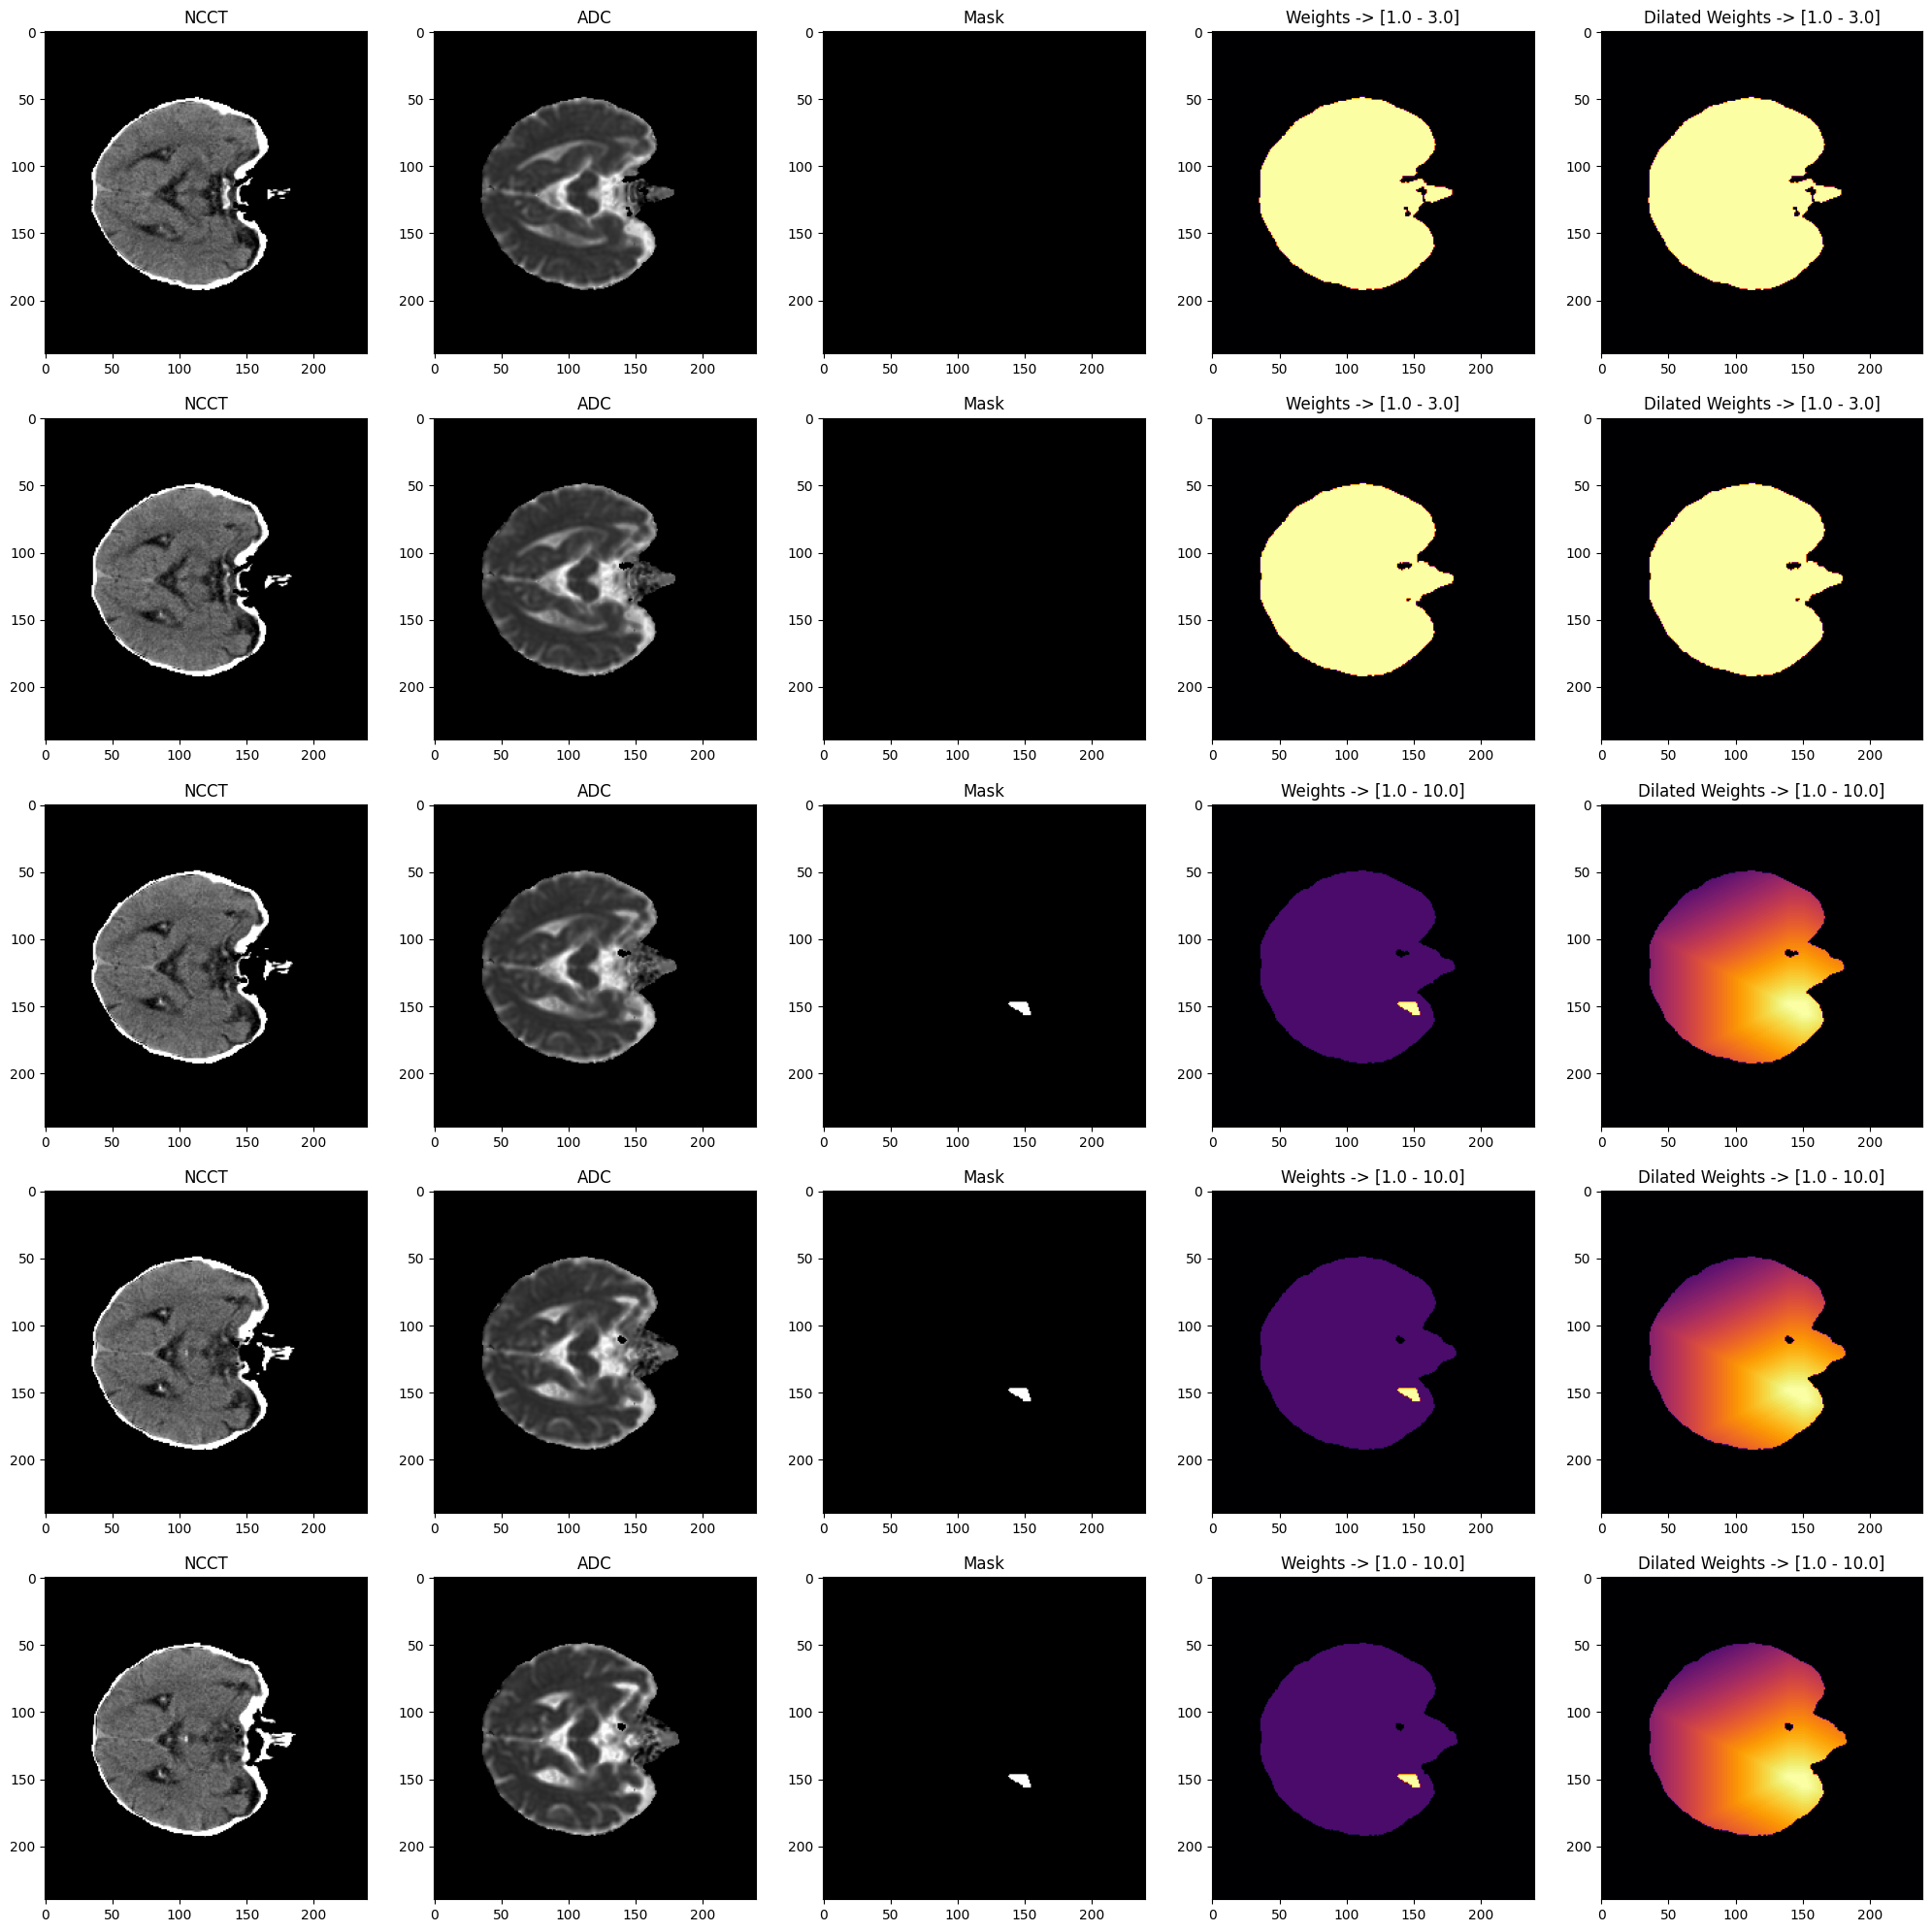

In [3]:
data = {"ncct": [], "adc": [], "mask": [], "weights": [], "dilated_weights": []}

class_weights = np.array([1.0, 3.0, 10.0])
patient_dir = Path("/data/stroke/APIS/preprocessed/synthsr/train/train_053")
patient_id = patient_dir.name

adc_path = patient_dir / f"{patient_id}_adc.nii.gz"
ncct_path = patient_dir / f"{patient_id}_ncct.nii.gz"
r1_mask_path = patient_dir / f"masks/{patient_id}_r1_mask.nii.gz"
bm_mask_path = patient_dir / f"derivatives/{patient_id}_adc_brain_mask.nii.gz"

assert adc_path.exists()
assert ncct_path.exists()
assert r1_mask_path.exists()
assert bm_mask_path.exists()

# Load weights.
adc = min_max_normalization(nib.load(adc_path).get_fdata())
ncct = min_max_normalization(nib.load(ncct_path).get_fdata())
r1_mask = nib.load(r1_mask_path).get_fdata()
bm_mask = nib.load(bm_mask_path).get_fdata()

# Compute sample weights.
weights = sample_weights(r1_mask + bm_mask, class_weights)  # 3-class.
dilated_weights = dilated_sample_weights(
    r1_mask, inf_val=class_weights[1], sup_val=class_weights[2]
)
dilated_weights = dilated_weights * bm_mask
dilated_weights[bm_mask == 0] = class_weights[0]

data["ncct"].append(ncct)
data["adc"].append(adc)
data["mask"].append(r1_mask)
data["weights"].append(weights)
data["dilated_weights"].append(dilated_weights)

sample_adc_path = patient_dir / "train_053_adc.nii.gz"
sample_adc = nib.load(sample_adc_path)

# Save class weights with the header and affine of the ADC image.
weights_nib = nib.Nifti1Image(data["weights"][0], sample_adc.affine, sample_adc.header)
# nib.save(weights_nib, "train_053_weights.nii.gz")

# Save dilated class weights with the header and affine of the ADC image.
dilated_weights_nib = nib.Nifti1Image(
    data["dilated_weights"][0], sample_adc.affine, sample_adc.header
)
# nib.save(dilated_weights_nib, "train_053_dilated_weights.nii.gz")

num_slices = 5
annotated_idxs = get_idxs_of_annotated_slices(data["mask"][0])
lower_idx = np.where(annotated_idxs)[0].min()
upper_idx = lower_idx + num_slices

annotated_ncct = data["ncct"][0][..., lower_idx-2:upper_idx-2]
annotated_adc = data["adc"][0][..., lower_idx-2:upper_idx-2]
annotated_mask = data["mask"][0][..., lower_idx-2:upper_idx-2]
annotated_weights = data["weights"][0][..., lower_idx-2:upper_idx-2]
annotated_dilated_weights = data["dilated_weights"][0][..., lower_idx-2:upper_idx-2]

# Plot all the images from above.
fig, axes = plt.subplots(num_slices, 5, figsize=(25, num_slices*5))
for i in range(num_slices):
    ncct_denorm = denorm_ct(annotated_ncct)
    axes[i, 0].imshow(window_image(ncct_denorm[..., i], 40, 80), cmap="gray")
    axes[i, 0].set_title("NCCT")
    axes[i, 1].imshow(annotated_adc[..., i], cmap="gray")
    axes[i, 1].set_title("ADC")
    axes[i, 2].imshow(annotated_mask[..., i], cmap="gray")
    axes[i, 2].set_title("Mask")
    axes[i, 3].imshow(annotated_weights[..., i], cmap="inferno")
    axes[i, 3].set_title(f"Weights -> [{annotated_weights[..., i].min()} - {annotated_weights[..., i].max()}]")
    axes[i, 4].imshow(annotated_dilated_weights[..., i], cmap="inferno")
    axes[i, 4].set_title(f"Dilated Weights -> [{annotated_dilated_weights[..., i].min()} - {annotated_dilated_weights[..., i].max()}]")

# TFRecord

Functions to serialize the data

In [4]:
def create_tfrecord(
    tfrecord_path: Union[str, Path], 
    patients_dirs: List[Path], 
    class_weights: np.ndarray,
    shuffle: bool = False,
):  
    
    if isinstance(tfrecord_path, Path):
        tfrecord_path = str(tfrecord_path)
        
    if not isinstance(class_weights, np.ndarray):
        class_weights = np.array(class_weights)

    assert class_weights.shape == (3,), "`class_weights` must be a 3-element array."

    shuffled_data = {"ncct": [], "adc": [], "r1_mask": [], "weights": [], "dilated_weights": []}
    with tf.io.TFRecordWriter(tfrecord_path) as writer:
        for patient_dir in tqdm(patients_dirs, desc="Creating TFRecord"):
            assert patient_dir.is_dir()
            patient_id = patient_dir.name

            adc_path = patient_dir / f"{patient_id}_adc.nii.gz"
            ncct_path = patient_dir / f"{patient_id}_ncct.nii.gz"
            r1_mask_path = patient_dir / f"masks/{patient_id}_r1_mask.nii.gz"
            bm_mask_path = patient_dir / f"derivatives/{patient_id}_adc_brain_mask.nii.gz"

            assert adc_path.exists()
            assert ncct_path.exists()
            assert r1_mask_path.exists()
            assert bm_mask_path.exists()

            # Load weights.
            adc = min_max_normalization(nib.load(adc_path).get_fdata())
            ncct = min_max_normalization(nib.load(ncct_path).get_fdata())
            r1_mask = nib.load(r1_mask_path).get_fdata()
            bm_mask = nib.load(bm_mask_path).get_fdata()

            # Compute sample weights.
            weights = sample_weights(r1_mask + bm_mask, class_weights)  # 3-class.
            dilated_weights = dilated_sample_weights(
                r1_mask, inf_val=class_weights[1], sup_val=class_weights[2]
            )
            dilated_weights = dilated_weights * bm_mask
            dilated_weights[bm_mask == 0] = class_weights[0]

            assert ncct.shape == adc.shape == r1_mask.shape == weights.shape == dilated_weights.shape

            for slice_idx in range(adc.shape[-1]):

                # If shuffle, append the slices of each modality and shuffle them later.
                if shuffle:
                    shuffled_data["ncct"].append(
                        np.expand_dims(ncct[..., slice_idx].astype(np.float32), -1)
                    )
                    shuffled_data["adc"].append(
                        np.expand_dims(adc[..., slice_idx].astype(np.float32), -1)
                    )
                    shuffled_data["r1_mask"].append(
                        np.expand_dims(r1_mask[..., slice_idx].astype(np.float32), -1)
                    )
                    shuffled_data["weights"].append(
                        np.expand_dims(weights[..., slice_idx].astype(np.float32), -1)
                    )
                    shuffled_data["dilated_weights"].append(
                        np.expand_dims(dilated_weights[..., slice_idx].astype(np.float32), -1)
                    )
                else:
                    serialized_features = serialize_example(
                        np.expand_dims(ncct[..., slice_idx].astype(np.float32), -1),
                        np.expand_dims(adc[..., slice_idx].astype(np.float32), -1),
                        np.expand_dims(r1_mask[..., slice_idx].astype(np.float32), -1),
                        np.expand_dims(weights[..., slice_idx].astype(np.float32), -1),
                        np.expand_dims(dilated_weights[..., slice_idx].astype(np.float32), -1),
                    )
                    writer.write(serialized_features)

        if shuffle:
            assert all(len(shuffled_data["ncct"]) == len(shuffled_data[k]) for k in shuffled_data)
            idxs = np.arange(len(shuffled_data["ncct"]))
            np.random.seed(2431)
            np.random.shuffle(idxs)
            for idx in tqdm(idxs, desc="Writing shuffled TFRecord"):
                serialized_features = serialize_example(
                    shuffled_data["ncct"][idx],
                    shuffled_data["adc"][idx],
                    shuffled_data["r1_mask"][idx],
                    shuffled_data["weights"][idx],
                    shuffled_data["dilated_weights"][idx],
                )
                writer.write(serialized_features)



def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()  # BytesList won't unpack a string from an EagerTensor.
    elif isinstance(value, str):
        value = value.encode("utf-8")
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    value = [value] if isinstance(value, int) else value
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def serialize_example(
    ncct: np.ndarray,
    adc: np.ndarray,
    mask: np.ndarray,
    weights: np.ndarray,
    dilated_weights: np.ndarray,
) -> tf.Tensor:
    feature = {
        "ncct": _bytes_feature(tf.io.serialize_tensor(ncct)),
        "ncct_shape": _int64_feature(list(ncct.shape)),
        "adc": _bytes_feature(tf.io.serialize_tensor(adc)),
        "adc_shape": _int64_feature(list(adc.shape)),
        "mask": _bytes_feature(tf.io.serialize_tensor(mask)),
        "mask_shape": _int64_feature(list(mask.shape)),
        "weights": _bytes_feature(tf.io.serialize_tensor(weights)),
        "weights_shape": _int64_feature(list(weights.shape)),
        "dilated_weights": _bytes_feature(tf.io.serialize_tensor(dilated_weights)),
        "dilated_weights_shape": _int64_feature(list(dilated_weights.shape)),
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

Create the dataset

In [6]:
# Create dataset directory.
data_dir = Path().absolute().parent / "data"
data_dir.mkdir(exist_ok=True)
class_weights = [1.0, 3.0, 10.0]
class_weights_str = [str(w) for w in class_weights]
class_weights_str = "_".join(class_weights_str).replace(".", "_")

tfrecord_dir = data_dir / f"APIS_synth-{class_weights_str}"
tfrecord_dir.mkdir(exist_ok=True)

source_dir = Path("/data/stroke/APIS/preprocessed/synthsr/")
train_dset = source_dir / "train"
test_dset = source_dir / "test"

train_patients = sorted(train_dset.iterdir())
train_patients, valid_patients = train_test_split(
    train_patients, test_size=0.16, random_state=2431
)

# Shuffle the training slices to avoid using shuffled buffer during training.
train_tfrecord_path = tfrecord_dir / "train.tfrecord"
create_tfrecord(train_tfrecord_path, train_patients, class_weights=np.array(class_weights), shuffle=True)

valid_tfrecord_path = tfrecord_dir / "valid.tfrecord"
create_tfrecord(valid_tfrecord_path, valid_patients, class_weights=np.array(class_weights), shuffle=False)

Creating TFRecord:   0%|          | 0/50 [00:00<?, ?it/s]

Writing shuffled TFRecord:   0%|          | 0/7543 [00:00<?, ?it/s]

2023-07-11 21:02:05.953573: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_INVALID_DEVICE: invalid device ordinal
2023-07-11 21:02:05.953639: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: 1660b6c49a51
2023-07-11 21:02:05.953647: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: 1660b6c49a51
2023-07-11 21:02:05.953952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: NOT_FOUND: was unable to find libcuda.so DSO loaded into this program
2023-07-11 21:02:05.954151: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.105.17


Creating TFRecord:   0%|          | 0/10 [00:00<?, ?it/s]